In [ ]:
import csv
import os
import random
import pickle
import pandas as pd
import numpy as np
from scipy import stats
import datetime
import matplotlib.pyplot as plt
from matplotlib import transforms
import sklearn
import warnings
import numpy as np
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patches as mpatches
from nilearn.datasets import load_mni152_template 
from nilearn import plotting, datasets
from nilearn.image import load_img, resample_to_img, new_img_like, math_img, coord_transform
from scipy.stats import pearsonr, zscore

import nibabel as nib
import mne
from mne import vertex_to_mni
from nilearn.plotting import plot_connectome

from matplotlib.path import Path
from matplotlib.patches import PathPatch, Circle
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import AgglomerativeClustering

# Feature importance for the top modaity

In [ ]:
modalities = ['struct_aseg_volume', 'struct_subsegmentation']

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

############## 1
seed = 42
folds = ["0", "1", "2", "3", "4"]
modality_dfs = {}
for modality in modalities:
    features = []
    g_pred = []
    pls_result = {}

    for fold in folds:
        features_corrected = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_test_corr_{fold}.csv')
        g_pred_test = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/g_pred/{modality}_g_pred_test_fold_{fold}.csv').drop(columns='Unnamed: 0')
        
        features.append(features_corrected)
        g_pred.append(g_pred_test)
    
    features_five_folds= pd.concat(features, axis=0, ignore_index=True)
    g_five_folds= pd.concat(g_pred, axis=0, ignore_index=True)

    smri_five_folds_best = pd.concat([g_five_folds, features_five_folds], axis=1)
    smri_five_folds_best.to_csv(f'/PLS/brain/feature_importance/{modality}_five_folds_best.csv')


    #############

    correlations = []
    for feature in features_five_folds.columns:
        r_pred, p_pred = stats.pearsonr(
        g_five_folds.iloc[:, 0].values,  # Ensure 1D array for g_pred
        features_five_folds[feature].values  # Current feature values
        )
    
        correlations.append({
        'feature': feature,
        'corr_with_g_pred': r_pred,  # Single float value
        'p_value_g_pred': p_pred     # Single float value
        })

    # Create DataFrame and sort
    modality_df = pd.DataFrame(correlations)
    output_dir = '/PLS/brain/feature_importance'
    output_path = os.path.join(output_dir, f'{modality}_corr_with_g_pred.csv')
    modality_df.to_csv(output_path, index=False)

In [ ]:
# Check values: struct_subsegmentation
output_dir = '/PLS/brain/feature_importance'
feature_import_subcort_subseg = pd.read_csv(os.path.join(output_dir, f'struct_subsegmentation_corr_with_g_pred.csv'))
feature_import_subcort_subseg.sort_values(
    'corr_with_g_pred', 
    key=lambda x: abs(x), 
    ascending=False).reset_index(drop=True)

#modalities = ['struct_aseg_volume', 'struct_subsegmentation']

feature  corr_with_g_pred  \
0    Volume of Whole-hippocampal-head (left hemisph...          0.478102   
1        Volume of Whole-hippocampus (left hemisphere)          0.466570   
2    Volume of Whole-hippocampal-head (right hemisp...          0.437071   
3       Volume of Whole-hippocampus (right hemisphere)          0.435593   
4    Volume of Accessory-Basal-nucleus (left hemisp...          0.428493   
..                                                 ...               ...   
116                     Volume of CL (left hemisphere)          0.035936   
117                    Volume of Pt (right hemisphere)          0.024624   
118                   Volume of PuL (right hemisphere)          0.012675   
119                        Volume of SCP (whole brain)         -0.008475   
120                    Volume of CL (right hemisphere)          0.001258   

     p_value_g_pred  
0      0.000000e+00  
1      0.000000e+00  
2      0.000000e+00  
3      0.000000e+00  
4      0.000000e+00  
..              ...  
116    3.048063e-09  
117    4.866092e-05  
118    3.655814e-02  
119    1.621816e-01  
120    8.356760e-01  

[121 rows x 3 columns]

In [ ]:
# Check values: struct_aseg_volume
feature_import_aseg_volume = pd.read_csv(os.path.join(output_dir, f'struct_aseg_volume_corr_with_g_pred.csv'))
feature_import_aseg_volume.sort_values(
    'corr_with_g_pred', 
    key=lambda x: abs(x), 
    ascending=False).reset_index(drop=True)

#modalities = ['struct_aseg_volume', 'struct_subsegmentation']

feature  corr_with_g_pred  \
0                   Volume of TotalGray (whole brain)          0.646978   
1         Volume of BrainSegNotVentSurf (whole brain)          0.638332   
2             Volume of BrainSegNotVent (whole brain)          0.630252   
3                    Volume of BrainSeg (whole brain)          0.596266   
4       Volume of SupraTentorialNotVent (whole brain)          0.572168   
5              Volume of SupraTentorial (whole brain)          0.536250   
6         Volume of Thalamus-Proper (left hemisphere)          0.533735   
7                  Volume of Cortex (left hemisphere)          0.507273   
8        Volume of Thalamus-Proper (right hemisphere)          0.506570   
9                 Volume of SubCortGray (whole brain)          0.491167   
10                Volume of Cortex (right hemisphere)          0.482047   
11            Volume of Hippocampus (left hemisphere)          0.473322   
12               Volume of Amygdala (left hemisphere)          0.452362   
13              Volume of 3rd-Ventricle (whole brain)         -0.450964   
14         Volume of Accumbens-area (left hemisphere)          0.442588   
15           Volume of Hippocampus (right hemisphere)          0.421733   
16     Volume of Cerebellum-Cortex (right hemisphere)          0.413353   
17      Volume of Cerebellum-Cortex (left hemisphere)          0.411635   
18             Volume of VentralDC (right hemisphere)          0.411503   
19  Volume of Cerebellum-White-Matter (left hemisp...          0.392131   
20              Volume of Amygdala (right hemisphere)          0.380697   
21    Volume of CerebralWhiteMatter (left hemisphere)          0.369215   
22        Volume of Accumbens-area (right hemisphere)          0.368191   
23              Volume of VentralDC (left hemisphere)          0.368084   
24         Volume of WM-hypointensities (whole brain)         -0.367562   
25        Volume of choroid-plexus (right hemisphere)         -0.366916   
26   Volume of CerebralWhiteMatter (right hemisphere)          0.361478   
27           Volume of Inf-Lat-Vent (left hemisphere)         -0.354017   
28  Volume of Cerebellum-White-Matter (right hemis...          0.347968   
29         Volume of choroid-plexus (left hemisphere)         -0.336842   
30                Volume of CC-Anterior (whole brain)          0.314943   
31               Volume of Optic-Chiasm (whole brain)         -0.290327   
32          Volume of Inf-Lat-Vent (right hemisphere)         -0.289366   
33            Volume of CC-Mid-Anterior (whole brain)          0.264294   
34           Volume of VentricleChoroid (whole brain)         -0.256822   
35                 Volume of CC-Central (whole brain)          0.242149   
36                Volume of Putamen (left hemisphere)          0.231003   
37  Volume of EstimatedTotalIntraCranial (whole br...          0.226730   
38               Volume of Putamen (right hemisphere)          0.213292   
39           Volume of CC-Mid-Posterior (whole brain)          0.211667   
40     Volume of Lateral-Ventricle (right hemisphere)         -0.211611   
41      Volume of Lateral-Ventricle (left hemisphere)         -0.195708   
42                 Volume of Brain-Stem (whole brain)          0.167230   
43               Volume of Pallidum (left hemisphere)          0.164272   
44               Volume of CC-Posterior (whole brain)          0.144695   
45              Volume of Pallidum (right hemisphere)          0.143327   
46                        Volume of CSF (whole brain)         -0.111038   
47                Volume of vessel (right hemisphere)         -0.107928   
48                 Volume of vessel (left hemisphere)         -0.086632   
49                Volume of Caudate (left hemisphere)          0.071466   
50              Volume of 5th-Ventricle (whole brain)          0.055132   
51               Volume of Caudate (right hemisphere)          0.041196   
52              Volume of 4th-Ventricle (whole brain)         -0.031396

In [ ]:
# Display nonsignificant correlations
feature_import_subcort_subseg.sort_values(
    'p_value_g_pred').round(2)

feature  corr_with_g_pred  \
0    Volume of Corticoamygdaloid-transitio (left he...              0.40   
1                 Volume of CA4-head (left hemisphere)              0.37   
2                Volume of CA3-head (right hemisphere)              0.35   
3          Volume of Lateral-nucleus (left hemisphere)              0.32   
4    Volume of Whole-hippocampal-head (right hemisp...              0.44   
..                                                 ...               ...   
54                      Volume of CL (left hemisphere)              0.04   
14                     Volume of Pt (right hemisphere)              0.02   
65                    Volume of PuL (right hemisphere)              0.01   
119                        Volume of SCP (whole brain)             -0.01   
29                     Volume of CL (right hemisphere)              0.00   

     p_value_g_pred  
0              0.00  
1              0.00  
2              0.00  
3              0.00  
4              0.00  
..              ...  
54             0.00  
14             0.00  
65             0.04  
119            0.16  
29             0.84  

[121 rows x 3 columns]

Freesurfer subfields:
[SubfieldAtlasesICBMspace](https://surfer.nmr.mgh.harvard.edu/fswiki/SubfieldAtlasesICBMspace?action=AttachFile&do=view&target=mni_icbm152_nlin_sym_09c_nifti.zip)

[Subfield atlases in MNI-ICBM 152 space (2009c symmetric)](https://surfer.nmr.mgh.harvard.edu/fswiki/SubfieldAtlasesICBMspace)

[Segmentation of hippocampal subfields and nuclei of the amygdala (cross-sectional and longitudinal)](https://surfer.nmr.mgh.harvard.edu/fswiki/HippocampalSubfieldsAndNucleiOfAmygdala)

Prepare data for plotting

In [ ]:
# 1 Get labels from each subcortical atlas
df = feature_import_subcort_subseg.copy()

# Initialize label dictionaries
t1_atlas_dir = '/feature-imp/smri/atlases/freesurfer_atlases'

label_maps = {
    'HippoAmyg': {},
    'Brainstem': {},
    'Thalamus': {}
}

# Parse all label files
for atlas_type in label_maps.keys():
    with open(os.path.join(t1_atlas_dir, f'{atlas_type}Probs.MNIsymSpace.names.txt')) as f:
        for i, line in enumerate(f):
            parts = line.strip().split(',')
            if len(parts) > 1:
                label_maps[atlas_type][i+1] = parts[1].lower().replace('-', '_')

In [ ]:
# Load atlases
def load_prob_atlas(atlas_path, names_path):
    """Load probabilistic atlas and return as dictionary of single-structure maps"""
    atlas_img = nib.load(atlas_path)
    atlas_data = atlas_img.get_fdata()
    
    # Read structure names
    with open(names_path) as f:
        structures = [line.strip().split(',')[1].lower().replace('-', '_') 
                     for line in f if len(line.strip().split(',')) > 1]
    
    # Create dictionary of single-structure maps
    prob_maps = {}
    for i, struct in enumerate(structures):
        prob_maps[struct] = atlas_data[..., i]  # Each volume is a structure
    
    return prob_maps, atlas_img

# Load all atlases
atlases = {
    'HippoAmyg_left': load_prob_atlas(
        os.path.join(t1_atlas_dir, 'HippoAmygProbs.MNIsymSpace.left.nii.gz'),
        os.path.join(t1_atlas_dir, 'HippoAmygProbs.MNIsymSpace.names.txt')
    ),
    'HippoAmyg_right': load_prob_atlas(
        os.path.join(t1_atlas_dir, 'HippoAmygProbs.MNIsymSpace.right.nii.gz'),
        os.path.join(t1_atlas_dir, 'HippoAmygProbs.MNIsymSpace.names.txt')
    ),
    'Thalamus': load_prob_atlas(
        os.path.join(t1_atlas_dir, 'ThalamusProbs.MNIsymSpace.nii.gz'),
        os.path.join(t1_atlas_dir, 'ThalamusProbs.MNIsymSpace.names.txt')
    ),
    'Brainstem': load_prob_atlas(
        os.path.join(t1_atlas_dir, 'BrainstemProbs.MNIsymSpace.nii.gz'),
        os.path.join(t1_atlas_dir, 'BrainstemProbs.MNIsymSpace.names.txt')
    )
}

In [ ]:
# 2 Match labels to UK BB featur names
def find_matching_label(feature_name, label_maps):
    """
    Enhanced matching function with targeted MV(Re) fix.
    All other functionality remains unchanged.
    """
    # Clean the feature name (preserve parentheses for MV(Re))
    clean_feature = re.sub(r'Volume of ', '', feature_name).strip().lower()
    clean_feature = clean_feature.replace('-', '_').replace(' ', '_')
    
    # Special case: MV(Re) in thalamus
    if 'mv(re)' in clean_feature:
        hemi = 'left' if 'left' in feature_name.lower() else 'right'
        return {
            'atlas': 'Thalamus',
            'label': 19 if hemi == 'left' else 42,
            'hemi': hemi,
            'fs_label': f"{hemi}_mv(re)"
        }
    
    # Original cleaning for other features (remove parentheses)
    clean_feature = re.sub(r'\(.*\)', '', clean_feature).strip('_')
    
    # Rest of original function remains identical...
    hemi = 'left' if 'left' in feature_name.lower() else 'right'
    
    for atlas_type, labels in label_maps.items():
        for label_num, label_name in labels.items():
            if atlas_type == 'Thalamus':
                thalamus_hemi = 'left' if label_name.startswith('left_') else 'right'
                if thalamus_hemi == hemi:
                    simple_label = label_name.replace('left_', '').replace('right_', '')
                    if simple_label in clean_feature:
                        return {
                            'atlas': atlas_type,
                            'label': label_num,
                            'hemi': hemi,
                            'fs_label': label_name
                        }
            else:
                if label_name in clean_feature:
                    return {
                        'atlas': atlas_type,
                        'label': label_num,
                        'hemi': hemi,
                        'fs_label': label_name
                    }
    
    return None

In [ ]:
# 3 Create feature mapping
feature_mapping = {}
for feature in df['feature']:
    # First try exact subfield matching
    match = find_matching_label(feature, label_maps)
    if match:
        feature_mapping[feature] = match
        continue
    else:
        print(f"Warning: No match found for {feature}")
        feature_mapping[feature] = {
            'status': 'unmatched',
            'notes': 'Manual inspection required'
        }
feature_mapping

{'Volume of Corticoamygdaloid-transitio (left hemisphere)': {'atlas': 'HippoAmyg',
  'label': 29,
  'hemi': 'left',
  'fs_label': 'corticoamygdaloid_transitio'},
 'Volume of CA4-head (left hemisphere)': {'atlas': 'HippoAmyg',
  'label': 17,
  'hemi': 'left',
  'fs_label': 'ca4_head'},
 'Volume of CA3-head (right hemisphere)': {'atlas': 'HippoAmyg',
  'label': 20,
  'hemi': 'right',
  'fs_label': 'ca3_head'},
 'Volume of Lateral-nucleus (left hemisphere)': {'atlas': 'HippoAmyg',
  'label': 22,
  'hemi': 'left',
  'fs_label': 'lateral_nucleus'},
 'Volume of Whole-hippocampal-head (right hemisphere)': {'type': 'composite',
  'atlas': 'HippoAmyg',
  'components': ['right_subiculum_head',
   'right_ca1_head',
   'right_presubiculum_head',
   'right_molecular_layer_hp_head',
   'right_gc_ml_dg_head',
   'right_ca3_head',
   'right_ca4_head'],
  'hemi': 'right',
  'notes': 'Sum of 7 subfields',
  'fs_label': 'whole_hippocampal_head'},
 'Volume of subiculum-body (left hemisphere)': {'atlas': '

In [ ]:
# 4 Define whole-structure to subfield mappings
WHOLE_STRUCTURE_COMPONENTS = {
    'whole_hippocampus': [
        'hippocampal_tail', 'subiculum_body', 'subiculum_head',
        'ca1_body', 'ca1_head', 'presubiculum_head', 'presubiculum_body',
        'parasubiculum', 'molecular_layer_hp_head', 'molecular_layer_hp_body',
        'gc_ml_dg_head', 'gc_ml_dg_body', 'ca3_body', 'ca3_head',
        'ca4_head', 'ca4_body', 'fimbria', 'hata'
    ],
    'whole_hippocampal_head': [
        'subiculum_head', 'ca1_head', 'presubiculum_head',
        'molecular_layer_hp_head', 'gc_ml_dg_head', 'ca3_head', 'ca4_head'
    ],
    'whole_hippocampal_body': [
        'subiculum_body', 'ca1_body', 'presubiculum_body',
        'molecular_layer_hp_body', 'gc_ml_dg_body', 'ca3_body', 'ca4_body'
    ],
    'whole_amygdala': [
        'lateral_nucleus', 'basal_nucleus', 'accessory_basal_nucleus',
        'anterior_amygdaloid_area_aaa', 'central_nucleus', 'medial_nucleus',
        'cortical_nucleus', 'corticoamygdaloid_transitio', 'paralaminar_nucleus'
    ],
    'whole_thalamus': [
        'lgn', 'mgn', 'pui', 'pum', 'l_sg', 'vpl', 'cm', 'vla', 
        'pua', 'mdm', 'pf', 'vamc', 'mdl', 'cem', 'va', 'mv(re)',
        'r', 'vm', 'cl', 'pul', 'pt', 'av', 'pc', 'vlp', 'lp', 'ld'
    ]
}

In [ ]:
# Print the first few thalamus components with their full names
print("Sample thalamus components with full names:")
for i, comp in enumerate(WHOLE_STRUCTURE_COMPONENTS['whole_thalamus']):
    print(f"{comp}:")
    print(f"  Left: left_{comp}")
    print(f"  Right: right_{comp}")
    if i > 5:  # Just show first 6 for example
        break

Sample thalamus components with full names:
lgn:
  Left: left_lgn
  Right: right_lgn
mgn:
  Left: left_mgn
  Right: right_mgn
pui:
  Left: left_pui
  Right: right_pui
pum:
  Left: left_pum
  Right: right_pum
l_sg:
  Left: left_l_sg
  Right: right_l_sg
vpl:
  Left: left_vpl
  Right: right_vpl
cm:
  Left: left_cm
  Right: right_cm


In [ ]:
def handle_whole_structures(feature_name):
    """Map whole-structure features to their component subfields"""
    # Clean the feature name
    clean_feature = (feature_name.lower()
                    .replace('volume of ', '')
                    .replace('-', '_')
                    .replace(' ', '_')
                    .replace('(whole_brain)', '')
                    .replace('(left_hemisphere)', '')
                    .replace('(right_hemisphere)', '')
                    .strip('_'))
    
    # Get hemisphere
    hemi = ('left' if 'left' in feature_name.lower() 
            else 'right' if 'right' in feature_name.lower() 
            else None)
    
    # Try to match each possible whole structure
    for whole_name, components in WHOLE_STRUCTURE_COMPONENTS.items():
        if whole_name in clean_feature:
            # Filter components by hemisphere if needed
            hemi_components = [
                f"{hemi}_{comp}" if hemi else comp 
                for comp in components
                if not comp.startswith(('left_', 'right_'))
            ]
            
            return {
                'type': 'composite',
                'atlas': 'HippoAmyg' if 'hippocamp' in whole_name or 'amygdala' in whole_name else 'Thalamus',
                'components': hemi_components,
                'hemi': hemi,
                'notes': f'Sum of {len(hemi_components)} subfields',
                'fs_label': whole_name
            }
    
    return None

# feature mapping
feature_mapping = {}
for feature in df['feature']:
    # First try exact subfield matching
    match = find_matching_label(feature, label_maps)
    if match:
        feature_mapping[feature] = match
        continue
        
    # Then check whole-structures
    whole_struct = handle_whole_structures(feature)
    if whole_struct:
        feature_mapping[feature] = whole_struct
        continue
        
    print(f"Warning: No match found for {feature}")
    feature_mapping[feature] = {
        'status': 'unmatched',
        'notes': 'Manual inspection required'
    }

In [ ]:
# Check label definitions in your HippoAmyg atlas
with open(os.path.join(t1_atlas_dir,'HippoAmygProbs.MNIsymSpace.names.txt')) as f:
    for i, line in enumerate(f):
        if 2 <= i+1 <= 21:
            print(f"Label {i+1}: {line.strip()}")  # Should show only hippocampal subfields

Label 2: 226,Hippocampal_tail
Label 3: 236,subiculum-body
Label 4: 238,CA1-body
Label 5: 235,subiculum-head
Label 6: 215,hippocampal-fissure
Label 7: 233,presubiculum-head
Label 8: 201,alveus
Label 9: 237,CA1-head
Label 10: 234,presubiculum-body
Label 11: 203,parasubiculum
Label 12: 245,molecular_layer_HP-head
Label 13: 246,molecular_layer_HP-body
Label 14: 243,GC-ML-DG-head
Label 15: 240,CA3-body
Label 16: 244,GC-ML-DG-body
Label 17: 241,CA4-head
Label 18: 242,CA4-body
Label 19: 212,fimbria
Label 20: 239,CA3-head
Label 21: 211,HATA


# Plot feature importances

In [ ]:
atlas_dir = '/feature-imp/smri/atlases/freesurfer_atlases'

In [ ]:
# Prepare data
def prepare_plotting_data(feature_mapping, feature_import_subcort_subseg):
    """Merge feature mapping with correlation values"""
    plot_data = []
    
    for feature, stats in feature_mapping.items():
        if stats.get('status') == 'unmatched':
            continue
            
        # Get correlation value
        corr = feature_import_subcort_subseg.loc[
            feature_import_subcort_subseg['feature'] == feature,
            'corr_with_g_pred'
        ].values[0]

        p_val = feature_import_subcort_subseg.loc[
            feature_import_subcort_subseg['feature'] == feature,
            'p_value_g_pred'
        ].values[0]
        
        # For composite structures (whole volumes), we'll plot them separately
        if stats.get('type') == 'composite':
            plot_data.append({
                'label': stats['fs_label'],
                'ukbb_label': feature,
                'atlas': stats['atlas'],
                'hemi': stats['hemi'],
                'correlation': corr,
                'p-value': p_val,
                'type': 'composite'
            })
        # For individual subfields
        elif 'fs_label' in stats:
            plot_data.append({
                'label': stats['fs_label'],
                'ukbb_label': feature,
                'atlas': stats['atlas'],
                'hemi': stats['hemi'],
                'correlation': corr,
                'p-value': p_val,
                'type': 'subfield'
            })
    
    return pd.DataFrame(plot_data)

plot_df = prepare_plotting_data(feature_mapping, feature_import_subcort_subseg)
plot_df.to_csv('/feature-imp/smri/plot_subcort.csv', index=False)
plot_df.columns.to_list()

['label', 'ukbb_label', 'atlas', 'hemi', 'correlation', 'p-value', 'type']

In [ ]:
# Map structure label to atlas index
label_to_index = {}
for feature, mapping in feature_mapping.items():
    # Skip composite structures and entries missing required keys
    if mapping.get('type') == 'composite':
        continue
    if 'fs_label' in mapping and 'label' in mapping:
        label_to_index[mapping['fs_label']] = mapping['label']
    else:
        print(f"Skipping feature {feature} - missing required mapping data")

print("Generated label-to-index mapping:")
print(label_to_index)

Generated label-to-index mapping:
{'corticoamygdaloid_transitio': 29, 'ca4_head': 17, 'ca3_head': 20, 'lateral_nucleus': 22, 'subiculum_body': 3, 'right_lp': 51, 'subiculum_head': 5, 'left_cm': 10, 'gc_ml_dg_head': 14, 'left_pf': 14, 'right_vm': 44, 'paralaminar_nucleus': 30, 'left_vpl': 9, 'right_pt': 49, 'right_vpl': 32, 'right_mdm': 36, 'right_av': 50, 'right_pf': 37, 'molecular_layer_hp_body': 13, 'left_pc': 26, 'midbrain': 5, 'left_mdm': 13, 'pons': 3, 'left_l_sg': 8, 'right_vla': 34, 'medulla': 2, 'right_pum': 30, 'left_vamc': 15, 'right_cl': 46, 'hata': 21, 'left_cem': 17, 'right_r': 40, 'right_vlp': 47, 'right_lgn': 3, 'right_pc': 48, 'cortical_nucleus': 28, 'anterior_amygdaloid_area_aaa': 25, 'parasubiculum': 11, 'right_mdl': 39, 'hippocampal_fissure': 6, 'left_pul': 23, 'left_ld': 52, 'ca4_body': 18, 'right_pua': 35, 'basal_nucleus': 23, 'right_vamc': 38, 'left_cl': 22, 'right_mv(re)': 42, 'left_mgn': 5, 'left_pum': 7, 'right_cem': 43, 'right_ld': 53, 'right_pul': 45, 'medial

In [ ]:
# Load probabilistic atlas (left hemisphere)
prob_atlas = nib.load(os.path.join(t1_atlas_dir, "HippoAmygProbs.MNIsymSpace.left.nii.gz"))
prob_data = prob_atlas.get_fdata()  # Shape: (x,y,z,N_subfields)
n_subfields = prob_data.shape[-1]  # Number of subfields in atlas

# Initialize correlation map
corr_map = np.zeros(prob_data.shape[:-1])

# Assign correlations to voxels
for _, row in plot_df.iterrows():
    if row['atlas'] == 'HippoAmyg' and row['hemi'] == 'left':
        label = row['label']
        if label in label_to_index:
            subfield_idx = label_to_index[label]
            if subfield_idx < n_subfields:  # Check if index is valid
                corr_map[prob_data[..., subfield_idx] > 0] = row['correlation']
            else:
                print(f"Warning: Index {subfield_idx} for label '{label}' exceeds atlas subfield count ({n_subfields})")
        else:
            print(f"Skipping unmapped label: {label}")

# Save correlation map
corr_img = nib.Nifti1Image(corr_map, affine=prob_atlas.affine)
nib.save(corr_img, "hippo_left_corr.nii.gz")

Skipping unmapped label: whole_hippocampal_body
Skipping unmapped label: whole_hippocampus
Skipping unmapped label: whole_hippocampal_head
Skipping unmapped label: whole_amygdala


Final glassbrain plot 

Processing HippoAmyg_left...
Processing HippoAmyg_right...
Processing Thalamus...
Processing Brainstem...


/tmp/ipykernel_81091/3161049141.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


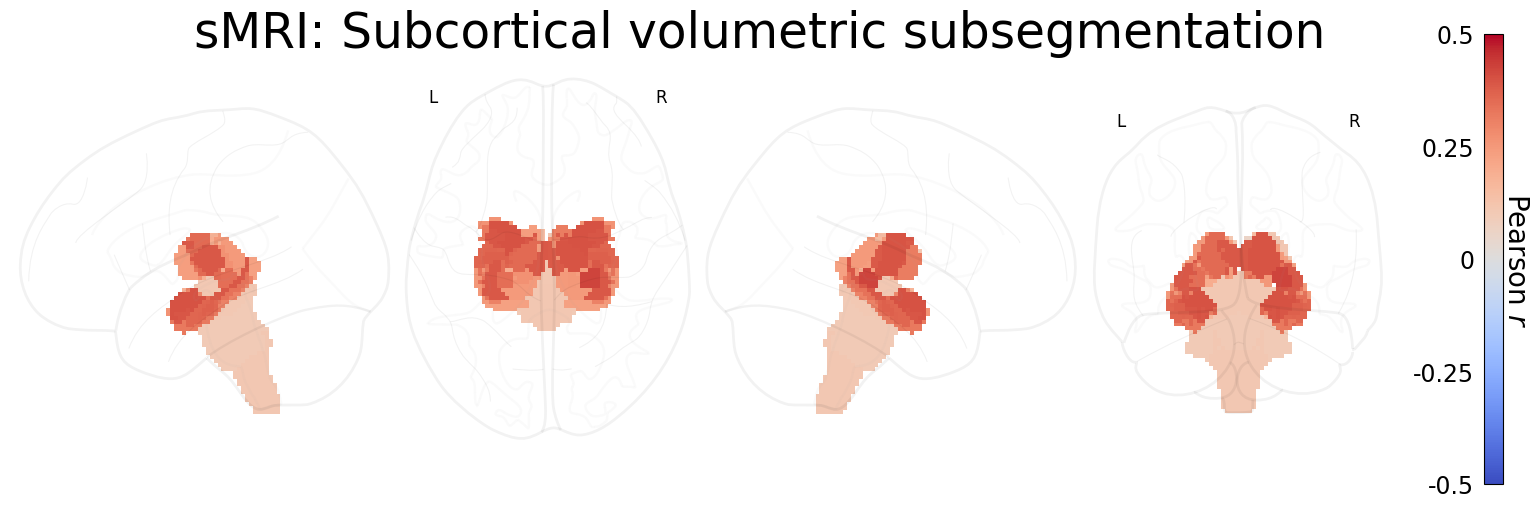

In [ ]:
# 4 slices
# 1. Initialize template space
significant_corr = plot_df.loc[plot_df['p-value'] <= 0.05, :]

template = load_mni152_template(resolution=2)
combined_data = np.zeros(template.shape[:3])

# 2. First process non-brainstem structures
for atlas_name, (prob_maps, atlas_img) in atlases.items():
    if 'Brainstem' in atlas_name:
        continue  # Process brainstem separately
        
    print(f"Processing {atlas_name}...")
    corr_data = np.zeros(atlas_img.shape[:3])
    
    for struct_name, prob_data in prob_maps.items():
        clean_name = struct_name.lower().replace('-', '_').replace(' ', '_')
        atlas_base = atlas_name.split('_')[0].lower()
        
        match = significant_corr[
            (significant_corr['label'].str.lower().str.replace('-', '_').str.replace(' ', '_') == clean_name) &
            (significant_corr['atlas'].str.lower() == atlas_base)
        ]
        
        if not match.empty:
            corr_value = match.iloc[0]['correlation']
            corr_data[prob_data > 0.1] = corr_value
    
    # Resample and combine
    corr_img = nib.Nifti1Image(corr_data, affine=atlas_img.affine)
    resampled = image.resample_to_img(corr_img, template, interpolation='nearest', force_resample=True, copy_header=True)
    combined_data = np.where(np.abs(resampled.get_fdata()) > np.abs(combined_data),
                           resampled.get_fdata(),
                           combined_data)

# 3. Now process brainstem separately with proper resampling
if 'Brainstem' in atlases:
    print("Processing Brainstem...")
    prob_maps, atlas_img = atlases['Brainstem']
    brainstem_corr_data = np.zeros(atlas_img.shape[:3])
    brainstem_mask = np.zeros(atlas_img.shape[:3])
    
    for struct_name, prob_data in prob_maps.items():
        if struct_name == 'background':
            continue
            
        clean_name = struct_name.lower().replace('-', '_').replace(' ', '_')
        match = significant_corr[significant_corr['label'].str.lower().str.replace('-', '_') == clean_name]
        
        if not match.empty:
            corr_value = match.iloc[0]['correlation']
            brainstem_corr_data[prob_data > 0.05] = corr_value
            brainstem_mask = np.maximum(brainstem_mask, (prob_data > 0.05).astype(int))
    
    # Resample brainstem data to template space
    corr_img = nib.Nifti1Image(brainstem_corr_data, affine=atlas_img.affine)
    resampled_corr = image.resample_to_img(corr_img, template, interpolation='nearest', force_resample=True, copy_header=True)
    
    mask_img = nib.Nifti1Image(brainstem_mask, affine=atlas_img.affine)
    resampled_mask = image.resample_to_img(mask_img, template, interpolation='nearest', force_resample=True, copy_header=True)
    
    # Apply mask and combine
    brainstem_data = resampled_corr.get_fdata() * (resampled_mask.get_fdata() > 0.5)
    combined_data = np.where(resampled_mask.get_fdata() > 0.5,
                           brainstem_data,
                           combined_data)

# 4. Visualization
fig = plt.figure(figsize=(15, 5))

# Create the glass brain plot and capture the returned display object
display = plotting.plot_glass_brain(
    nib.Nifti1Image(combined_data, affine=template.affine),
    cmap='coolwarm',
    threshold=0.0,
    vmin=-0.5, vmax=0.5,
    display_mode='lzry',
    figure=fig,
    colorbar=True,
    plot_abs=False,
    alpha=0.05
)

# Access the colorbar and modify its properties
colorbar = display._cbar
if colorbar is not None:
    # Set colorbar label
    colorbar.set_label('Pearson $r$', rotation=270, labelpad=20, fontsize=20)
    # Adjust colorbar tick font size
    colorbar.ax.tick_params(labelsize=17)

fig.suptitle(
    "sMRI: Subcortical volumetric subsegmentation",
    y=1,
    fontsize=35
)

plt.tight_layout()
fig_path = '/feature-imp/figures'
plt.savefig(os.path.join(fig_path, 'fi-smri.png'), dpi=300, bbox_inches='tight')
plt.show()

Processing HippoAmyg_left...
Processing HippoAmyg_right...
Processing Thalamus...
Processing Brainstem...


/tmp/ipykernel_81091/2641652724.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


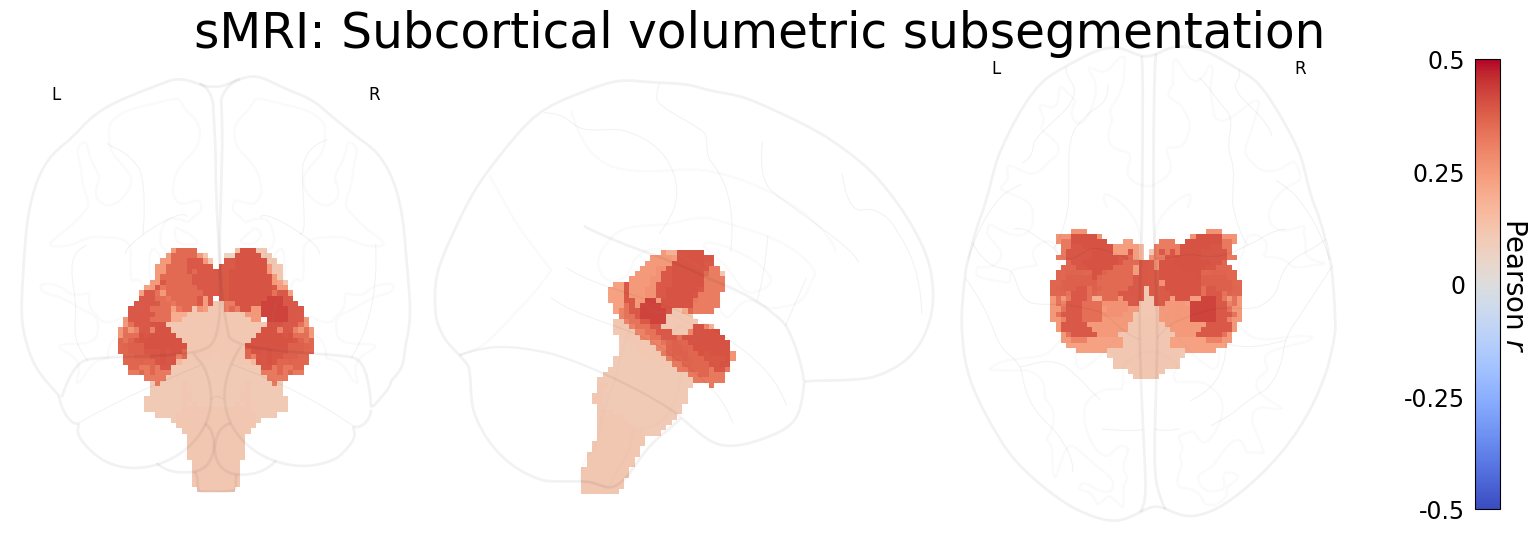

In [ ]:
# 3 slices
# 1. Initialize template space
significant_corr = plot_df.loc[plot_df['p-value'] <= 0.05, :]

template = load_mni152_template(resolution=2)
combined_data = np.zeros(template.shape[:3])

# 2. First process non-brainstem structures
for atlas_name, (prob_maps, atlas_img) in atlases.items():
    if 'Brainstem' in atlas_name:
        continue  # Process brainstem separately
        
    print(f"Processing {atlas_name}...")
    corr_data = np.zeros(atlas_img.shape[:3])
    
    for struct_name, prob_data in prob_maps.items():
        clean_name = struct_name.lower().replace('-', '_').replace(' ', '_')
        atlas_base = atlas_name.split('_')[0].lower()
        
        match = significant_corr[
            (significant_corr['label'].str.lower().str.replace('-', '_').str.replace(' ', '_') == clean_name) &
            (significant_corr['atlas'].str.lower() == atlas_base)
        ]
        
        if not match.empty:
            corr_value = match.iloc[0]['correlation']
            corr_data[prob_data > 0.1] = corr_value
    
    # Resample and combine
    corr_img = nib.Nifti1Image(corr_data, affine=atlas_img.affine)
    resampled = image.resample_to_img(corr_img, template, interpolation='nearest', force_resample=True, copy_header=True)
    combined_data = np.where(np.abs(resampled.get_fdata()) > np.abs(combined_data),
                           resampled.get_fdata(),
                           combined_data)

# 3. Now process brainstem separately with proper resampling
if 'Brainstem' in atlases:
    print("Processing Brainstem...")
    prob_maps, atlas_img = atlases['Brainstem']
    brainstem_corr_data = np.zeros(atlas_img.shape[:3])
    brainstem_mask = np.zeros(atlas_img.shape[:3])
    
    for struct_name, prob_data in prob_maps.items():
        if struct_name == 'background':
            continue
            
        clean_name = struct_name.lower().replace('-', '_').replace(' ', '_')
        match = significant_corr[significant_corr['label'].str.lower().str.replace('-', '_') == clean_name]
        
        if not match.empty:
            corr_value = match.iloc[0]['correlation']
            brainstem_corr_data[prob_data > 0.05] = corr_value
            brainstem_mask = np.maximum(brainstem_mask, (prob_data > 0.05).astype(int))
    
    # Resample brainstem data to template space
    corr_img = nib.Nifti1Image(brainstem_corr_data, affine=atlas_img.affine)
    resampled_corr = image.resample_to_img(corr_img, template, interpolation='nearest', force_resample=True, copy_header=True)
    
    mask_img = nib.Nifti1Image(brainstem_mask, affine=atlas_img.affine)
    resampled_mask = image.resample_to_img(mask_img, template, interpolation='nearest', force_resample=True, copy_header=True)
    
    # Apply mask and combine
    brainstem_data = resampled_corr.get_fdata() * (resampled_mask.get_fdata() > 0.5)
    combined_data = np.where(resampled_mask.get_fdata() > 0.5,
                           brainstem_data,
                           combined_data)

# 4. Visualization
fig = plt.figure(figsize=(15, 5))

# Create the glass brain plot and capture the returned display object
display = plotting.plot_glass_brain(
    nib.Nifti1Image(combined_data, affine=template.affine),
    cmap='coolwarm',
    threshold=0.0,
    vmin=-0.5, vmax=0.5,
    display_mode='ortho',
    figure=fig,
    colorbar=True,
    plot_abs=False,
    alpha=0.05
)

# Access the colorbar and modify its properties
colorbar = display._cbar
if colorbar is not None:
    # Set colorbar label
    colorbar.set_label('Pearson $r$', rotation=270, labelpad=20, fontsize=20)
    # Adjust colorbar tick font size
    colorbar.ax.tick_params(labelsize=17)

fig.suptitle(
    "sMRI: Subcortical volumetric subsegmentation",
    y=1.05,
    fontsize=35
)

plt.tight_layout()
fig_path = 'plots'
plt.savefig(os.path.join(fig_path, 'fi-smri.png'), dpi=300, bbox_inches='tight')
plt.show()

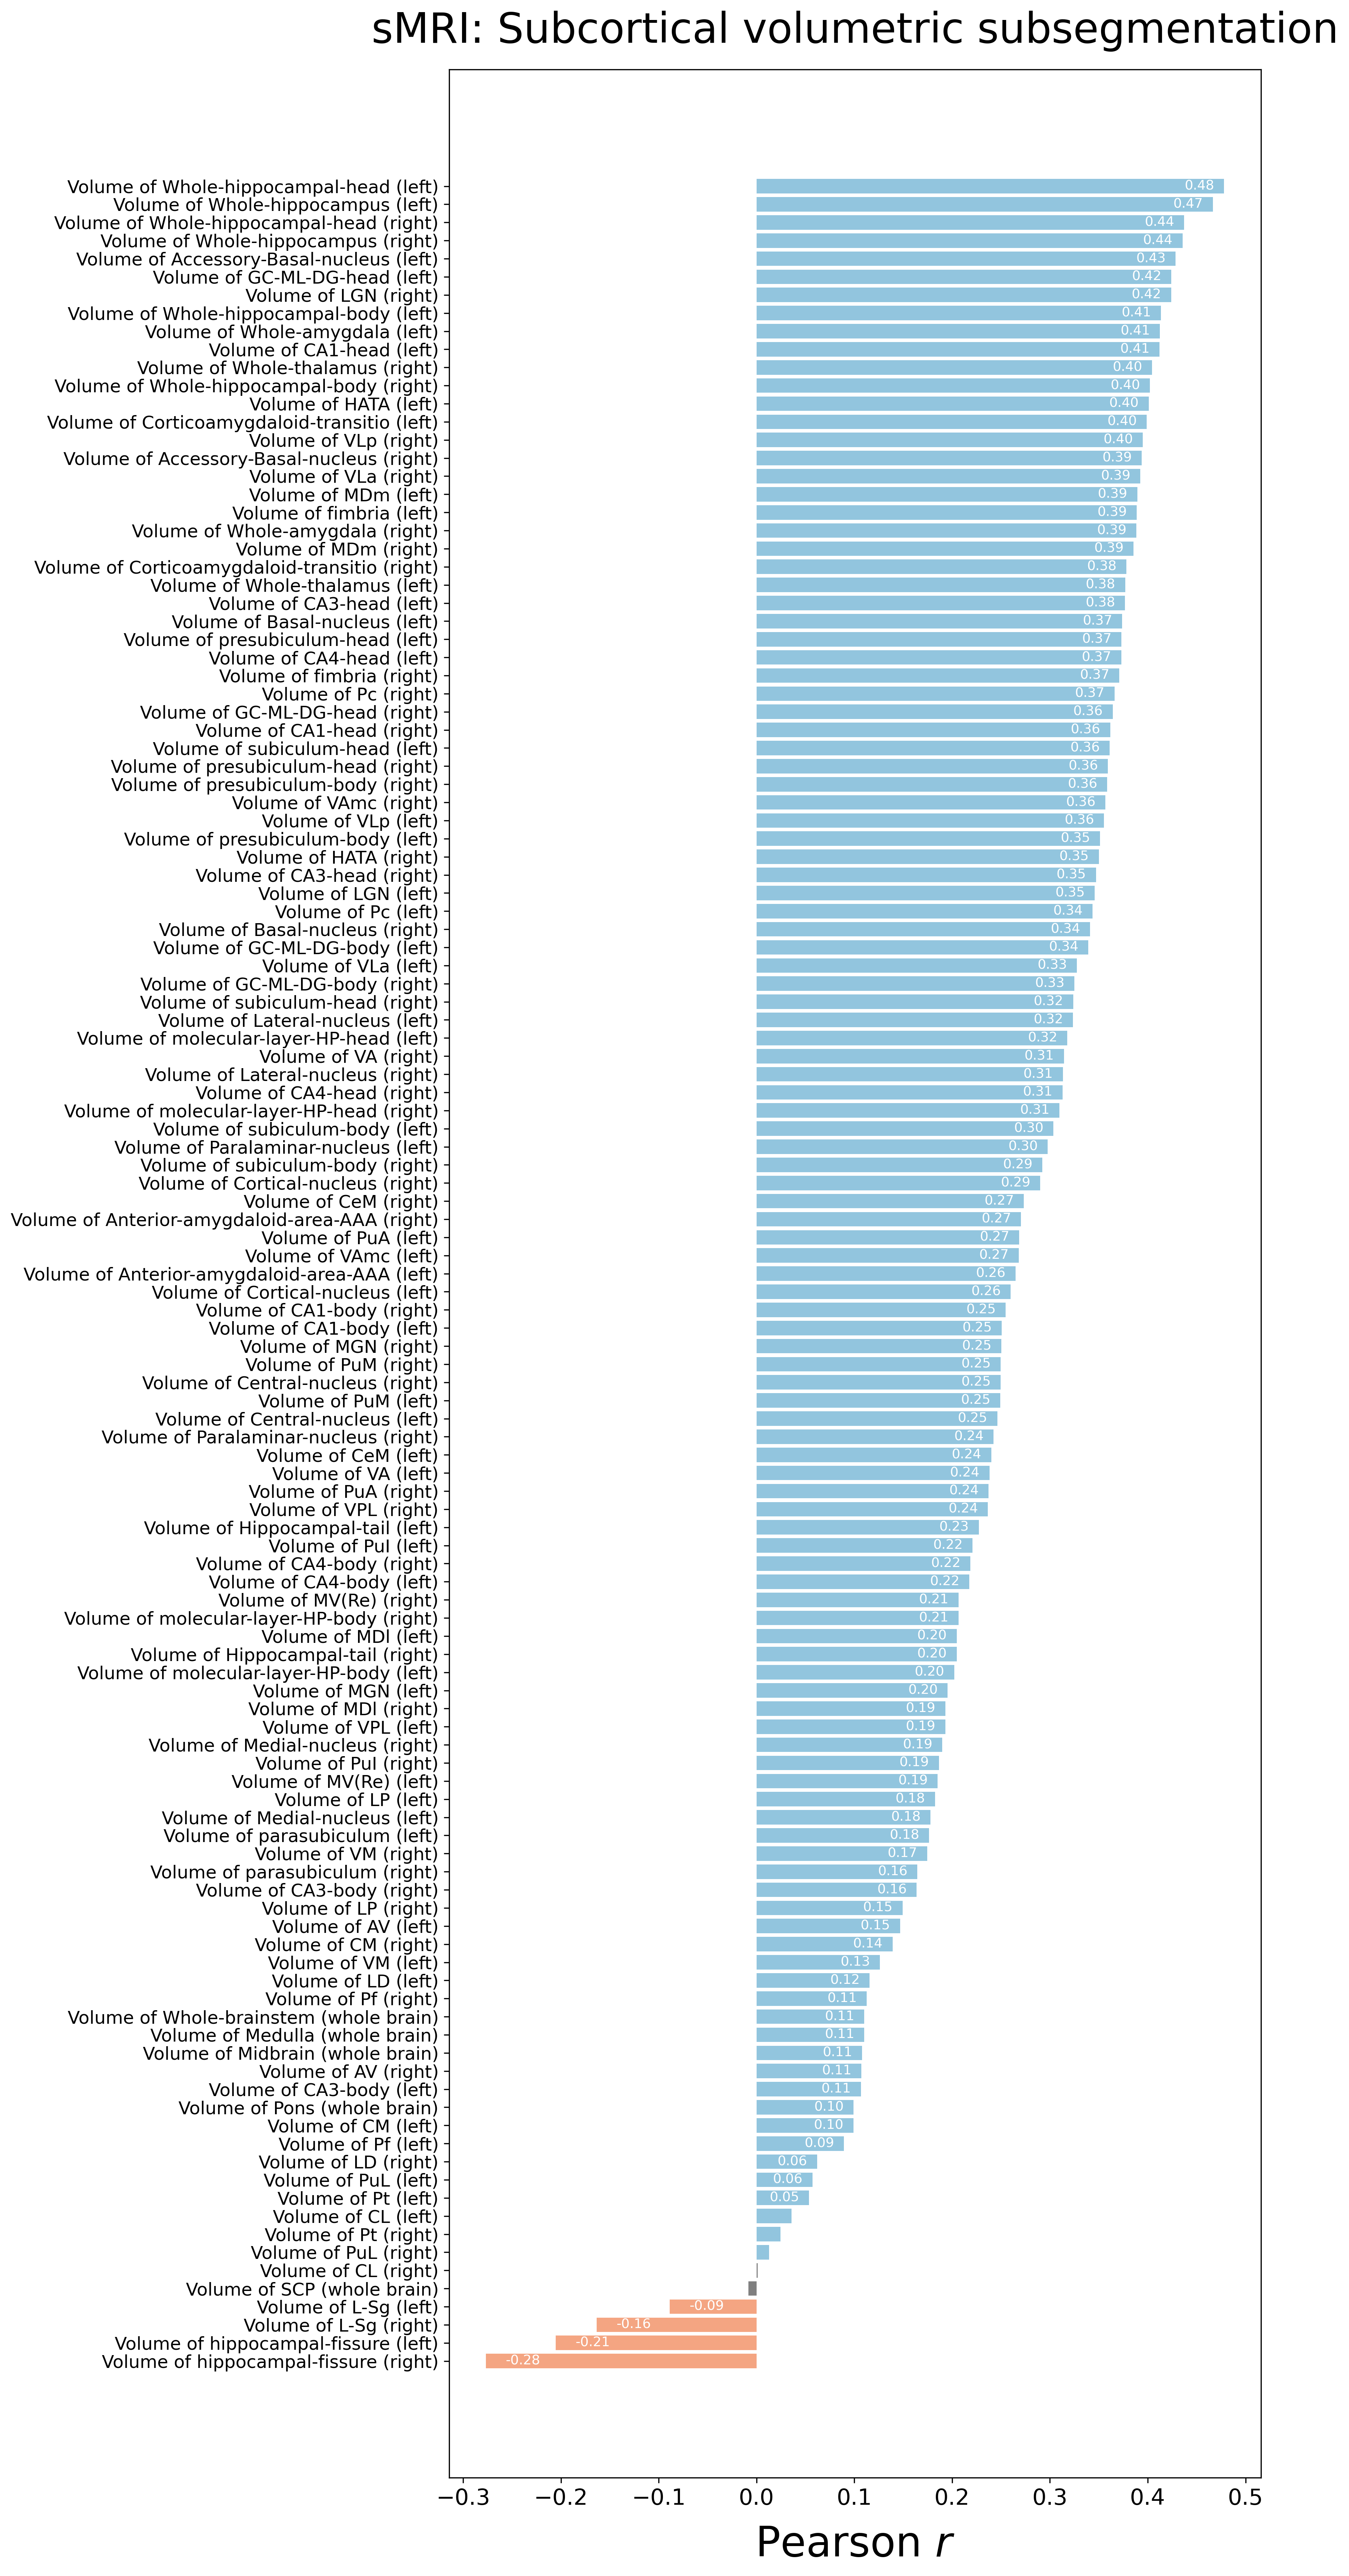

In [ ]:
# Plot all feature importances without filtering
ordered = (plot_df
         .assign(abs_corr = plot_df['correlation'].abs())
         .sort_values('abs_corr', ascending=False)
         ).sort_values('correlation', ascending=False)  # Sort by actual correlation for plotting

# Create the figure - adjust size based on number of remaining bars
n_bars = len(ordered)
plt.figure(figsize=(10, max(6, n_bars * 0.18)), dpi=300)  # Dynamic height

# Create color list - default colors first
colors = ['#92C5DEFF' if x > 0 else '#F4A582FF' for x in ordered['correlation']]

# Identify labels to make grey
grey_labels = [
    'Volume of CL (right hemisphere)',
    'Volume of SCP (whole brain)'
]

# Apply grey color to specific labels
for i, label in enumerate(ordered['ukbb_label']):
    if label in grey_labels:
        colors[i] = '#808080'  # Grey color

# Create bars
bars = plt.barh(ordered['ukbb_label'].str.replace(' hemisphere', ''), 
                ordered['correlation'], 
                color=colors)

# Add correlation values only for |r| ≥ 0.05
for bar, corr in zip(bars, ordered['correlation']):
    if abs(corr) >= 0.05:  # Only show values for significant correlations
        width = bar.get_width()
        label_x = width - 0.01 if width > 0 else width + 0.02
        plt.text(label_x, bar.get_y() + bar.get_height()/2,
                 f'{width:.2f}',
                 va='center', ha='right' if width > 0 else 'left',
                 color='white', fontsize=9)

# Rest of your plotting code remains the same
plt.title(f'sMRI: Subcortical volumetric subsegmentation', 
          pad=18, fontsize=28)
plt.xlabel('Pearson $r$', labelpad=10, fontsize=28)
plt.xticks(fontsize=20)
plt.ylabel('')
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()

fig_path = '/feature-imp/smri'
plt.savefig(os.path.join(fig_path, 'fi-smri-BARS.png'), dpi=300, bbox_inches='tight')
plt.show()

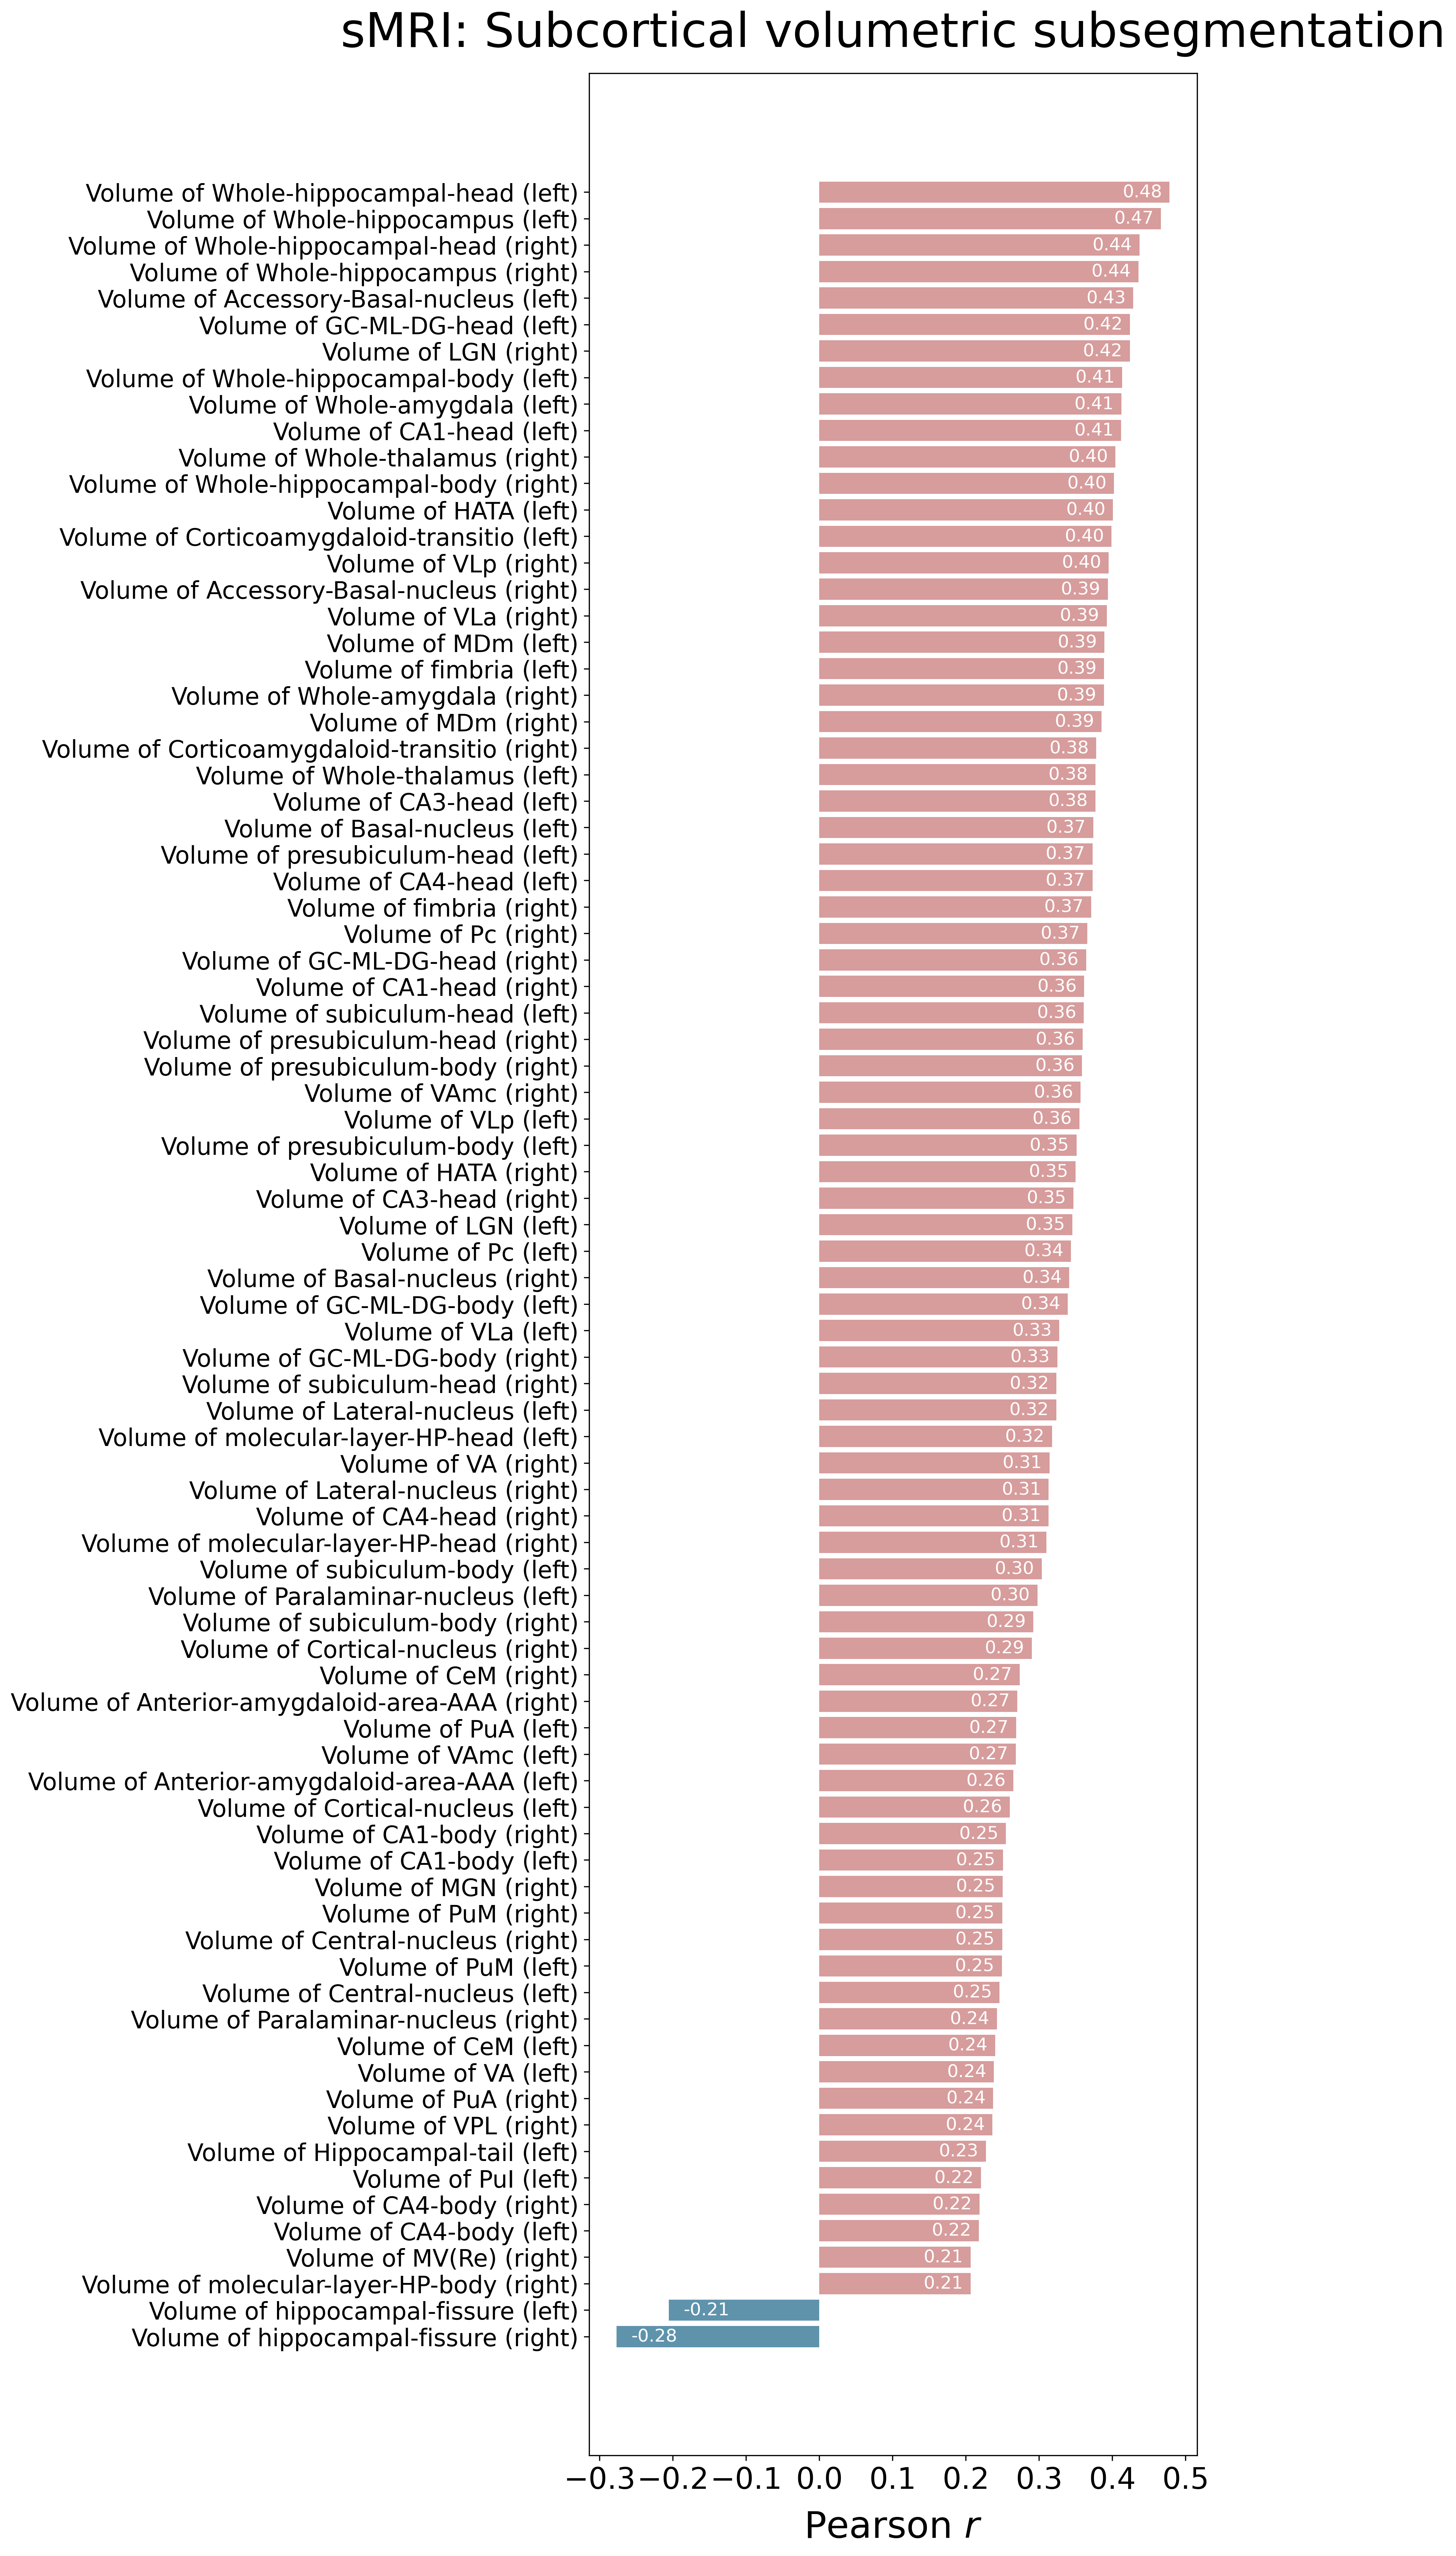

In [ ]:
# Barplot: filter to only show correlations > 0.2 in absolute value
plot_df_filtered = plot_df[plot_df['correlation'].abs() > 0.205]

# Sort the filtered data
ordered = (plot_df_filtered
         .assign(abs_corr = plot_df_filtered['correlation'].abs())
         .sort_values('abs_corr', ascending=False)
         ).sort_values('correlation', ascending=False)

# Create the figure with larger dimensions
n_bars = len(ordered)
plt.figure(figsize=(12, max(10, n_bars * 0.3)), dpi=300)  # Increased width and bar height

# Create color list
colors = ['#D79C9CFF' if x > 0 else '#5F93ACFF' for x in ordered['correlation']]

# Apply grey color to specific labels
grey_labels = [
    'Volume of CL (right hemisphere)',
    'Volume of SCP (whole brain)'
]
for i, label in enumerate(ordered['ukbb_label']):
    if label in grey_labels:
        colors[i] = '#808080'

# Create bars with slightly thicker bars
bars = plt.barh(ordered['ukbb_label'].str.replace(' hemisphere', ''), 
                ordered['correlation'], 
                color=colors,
                height=0.8)  # Increased bar thickness

# Add correlation values with larger font
for bar, corr in zip(bars, ordered['correlation']):
    width = bar.get_width()
    label_x = width - 0.01 if width > 0 else width + 0.02
    plt.text(label_x, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}',
             va='center', ha='right' if width > 0 else 'left',
             color='white', fontsize=12)  # Increased from 9 to 12

# Increase all font sizes
plt.title(f'sMRI: Subcortical volumetric subsegmentation', 
          pad=18, fontsize=32)  # Increased from 28 to 32
plt.xlabel('Pearson $r$', labelpad=10, fontsize=25)  # Increased from 28 to 28
plt.xticks(fontsize=20)  # Increased from 25 to 22
plt.ylabel('')
plt.yticks(fontsize=16)  # Increased from 12 to 16
plt.gca().invert_yaxis()

# Adjust layout with more padding
plt.tight_layout(pad=3.0)  # Increased padding

# Save with higher quality
fig_path = '/feature-imp/figures/supplem'
plt.savefig(os.path.join(fig_path, 'fi-smri-BARS.jpg'), 
            dpi=350,  # Increased from 300 to 350
            bbox_inches='tight')
plt.show()

In [ ]:
plot_df[plot_df['atlas'] == 'Brainstem'].round(2)

label                        ukbb_label      atlas   hemi  \
21   midbrain  Volume of Midbrain (whole brain)  Brainstem  right   
23       pons      Volume of Pons (whole brain)  Brainstem  right   
26    medulla   Volume of Medulla (whole brain)  Brainstem  right   
119       scp       Volume of SCP (whole brain)  Brainstem  right   

     correlation  p-value      type  
21          0.11     0.00  subfield  
23          0.10     0.00  subfield  
26          0.11     0.00  subfield  
119        -0.01     0.16  subfield

In [ ]:
print(plot_df['correlation'].max())
print(plot_df['correlation'].min())

0.4781017342806891
-0.2766892605045237
